In [24]:
%pip install tensorflow
import tensorflow as tf


Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
data = pd.read_csv(r"C:\Users\ADMIN\Downloads\_classes.csv")

In [28]:
train_dir = r"C:\Users\ADMIN\Downloads\train\train"
val_dir = r"C:\Users\ADMIN\Downloads\valid\valid"
test_dir = r"C:\Users\ADMIN\Downloads\test\test"

DATA AUGMENTATION

In [29]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  

    # Data augmentation parameters
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    zoom_range=0.2,  
    horizontal_flip=True,  
    vertical_flip=False, 
    fill_mode='nearest'  
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [31]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


MODEL BUILDING

In [32]:
from tensorflow.keras import layers, models

custom_model = models.Sequential([
    # 👇 Clean Input Layer
    layers.Input(shape=(224, 224, 3)),

    # 🔹 Convolution Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # 🔹 Convolution Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # 🔹 Convolution Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),


    # 🔹 Flatten + Dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

custom_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')],
    
)

custom_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 10
custom_history = custom_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3787 - loss: 1.5096 - precision: 0.4002 - recall: 0.1061 - val_accuracy: 0.5125 - val_loss: 1.0155 - val_precision: 0.7680 - val_recall: 0.3104
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.5938 - loss: 1.0286 - precision: 0.7368 - recall: 0.4375 - val_accuracy: 0.5125 - val_loss: 1.0101 - val_precision: 0.7783 - val_recall: 0.3292
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5688 - loss: 1.0545 - precision: 0.6986 - recall: 0.2967 - val_accuracy: 0.5458 - val_loss: 0.9487 - val_precision: 0.7100 - val_recall: 0.3979
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.8125 - loss: 0.5678 - precision: 0.9167 - recall: 0.6875 - val_accuracy: 0.5750 - val_loss: 0.9630 - val_precision: 0.6787 - val_recall: 0.4313
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6501 - loss: 0.9205 - precision: 0.7297 - recall: 0.4701 - val_accuracy: 0.6771 - val_loss: 0.8267 - v

In [34]:
test_loss, test_acc, test_precision, test_recall = custom_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.6774 - loss: 0.8656 - precision: 0.7494 - recall: 0.5963

Test accuracy: 0.6951
Test precision: 0.7677
Test recall: 0.6179


In [35]:
test_generator.reset()
predictions =custom_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step


In [36]:
true_classes = test_generator.classes

print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.75      0.77        80
  meningioma       0.66      0.40      0.50        63
    no_tumor       0.56      0.92      0.69        49
   pituitary       0.79      0.76      0.77        54

    accuracy                           0.70       246
   macro avg       0.70      0.71      0.68       246
weighted avg       0.71      0.70      0.69       246


Confusion Matrix:
[[60 11  7  2]
 [11 25 19  8]
 [ 1  2 45  1]
 [ 3  0 10 41]]


In [75]:
def plot_history(custom_history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(custom_history.history['accuracy'], label='Training Accuracy')
    plt.plot(custom_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(custom_history.history['loss'], label='Training Loss')
    plt.plot(custom_history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

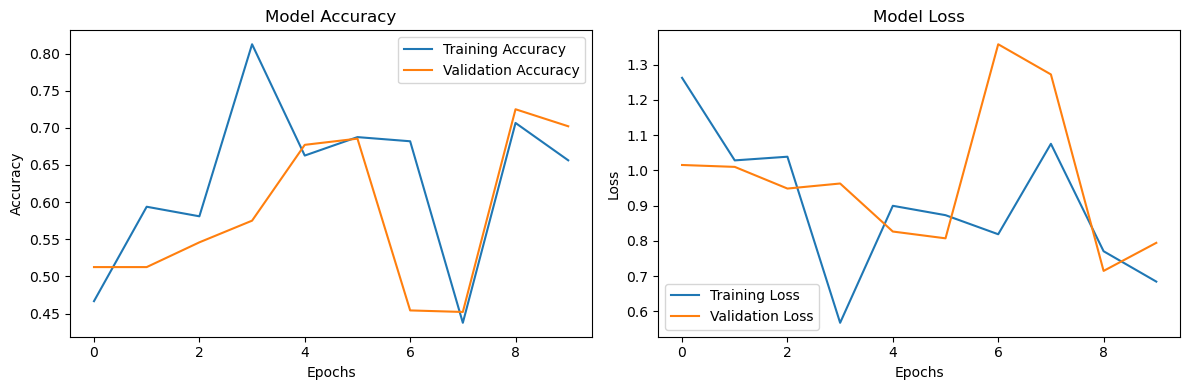

In [76]:
plot_history(custom_history)

PRETRAINED MODELS

In [ ]:
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0,ResNet50V2,InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
model_comparison = []

def evaluate_mobilenet():
# Load MobileNetV2 base model
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,     
        weights='imagenet'     
    )
    base_model.trainable = False # Freeze all layers (initially)

    mobilenet_model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense((num_classes), activation='softmax')  
    ])

    mobilenet_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall'])

    history_transfer = mobilenet_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    return mobilenet_model,mobilenet_history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.3953 - loss: 1.4854 - precision: 0.4404 - recall: 0.2923 - val_accuracy: 0.7072 - val_loss: 0.6813 - val_precision: 0.7789 - val_recall: 0.6315
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 959ms/step - accuracy: 0.6907 - loss: 0.7862 - precision: 0.7358 - recall: 0.6179 - val_accuracy: 0.7351 - val_loss: 0.6635 - val_precision: 0.7763 - val_recall: 0.6912
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 954ms/step - accuracy: 0.7650 - loss: 0.6070 - precision: 0.7930 - recall: 0.7214 - val_accuracy: 0.7629 - val_loss: 0.5887 - val_precision: 0.8088 - val_recall: 0.7331
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 953ms/step - accuracy: 0.7778 - loss: 0.5662 - precision: 0.8172 - recall: 0.7451 - val_accuracy: 0.8068 - val_loss: 0.5017 - val_precision: 0.8515 - val_recall: 0.7769
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 51s 961ms/step - accuracy: 0.8186 - loss: 0.4615 - precision: 0.8532 - recall: 0.7923 - val_accuracy: 0.7789 - val_loss: 

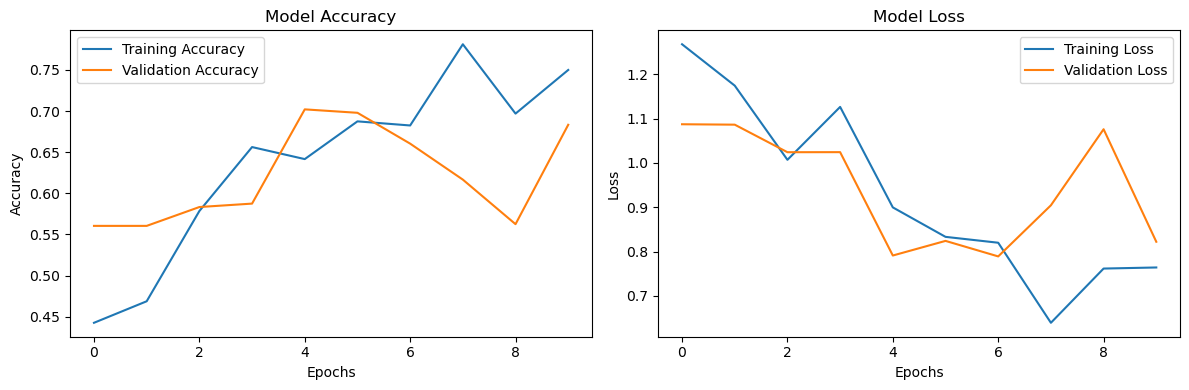

In [39]:
plot_history(mobilenet_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.7769 - loss: 0.5774 - precision: 0.7921 - recall: 0.7523

Test accuracy: 0.7886
Test precision: 0.8095
Test recall: 0.7602
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 608ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.88      0.86        80
  meningioma       0.84      0.51      0.63        63
    no_tumor       0.93      0.78      0.84        49
   pituitary       0.64      1.00      0.78        54

    accuracy                           0.79       246
   macro avg       0.81      0.79      0.78       246
weighted avg       0.82      0.79      0.78       246



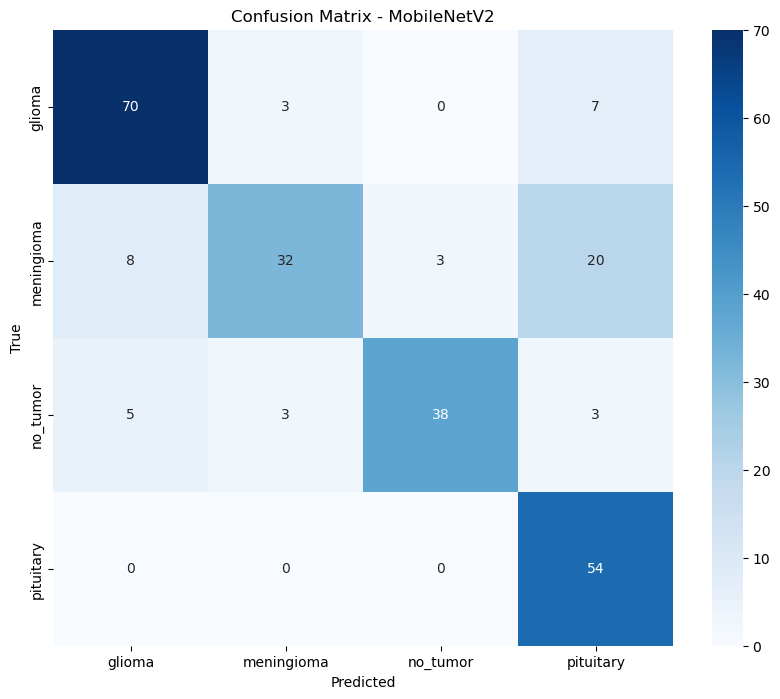

In [40]:

test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')
test_generator.reset()

predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

conf_mat = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

In [65]:
def evaluate_efficientnet():
    base_model = EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    efficientnet_model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense((num_classes), activation='softmax')
    ])

    efficientnet_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall'])

    efficientnet_history = efficientnet_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    return efficientnet_model,efficientnet_history

efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNet',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Moderate',
    'Best For': 'Balanced performance'
})

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.2795 - loss: 1.4342 - precision: 0.2832 - recall: 0.0082 - val_accuracy: 0.3207 - val_loss: 1.3704 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2785 - loss: 1.4050 - precision: 0.3865 - recall: 0.0083 - val_accuracy: 0.3207 - val_loss: 1.3810 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2957 - loss: 1.3967 - precision: 0.2839 - recall: 0.0039 - val_accuracy: 0.3207 - val_loss: 1.3835 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3108 - loss: 1.3937 - precision: 0.5482 - recall: 0.0055 - val_accuracy: 0.2351 - val_loss: 1.3967 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


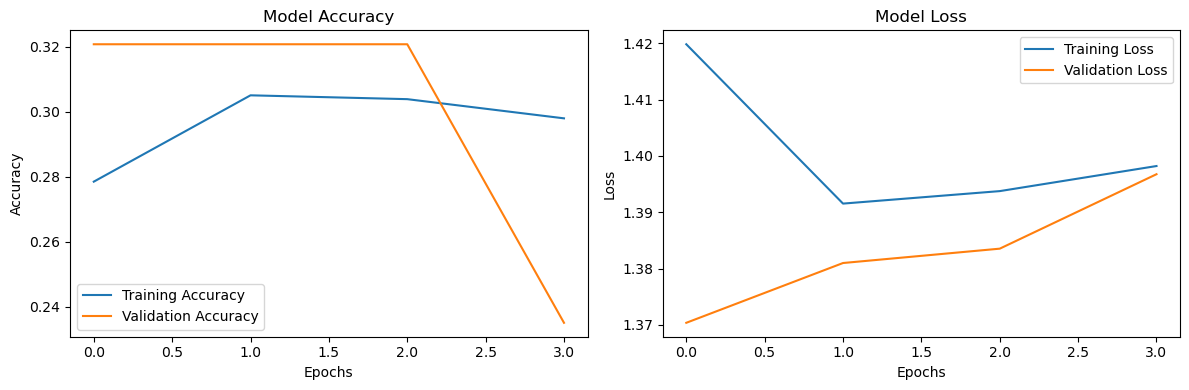

In [66]:
plot_history(efficientnet_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.0647 - loss: 1.4430 - precision: 0.0000e+00 - recall: 0.0000e+00  

Test accuracy: 0.2195
Test precision: 0.0000
Test recall: 0.0000
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 932ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.22      1.00      0.36        54

    accuracy                           0.22       246
   macro avg       0.05      0.25      0.09       246
weighted avg       0.05      0.22      0.08       246



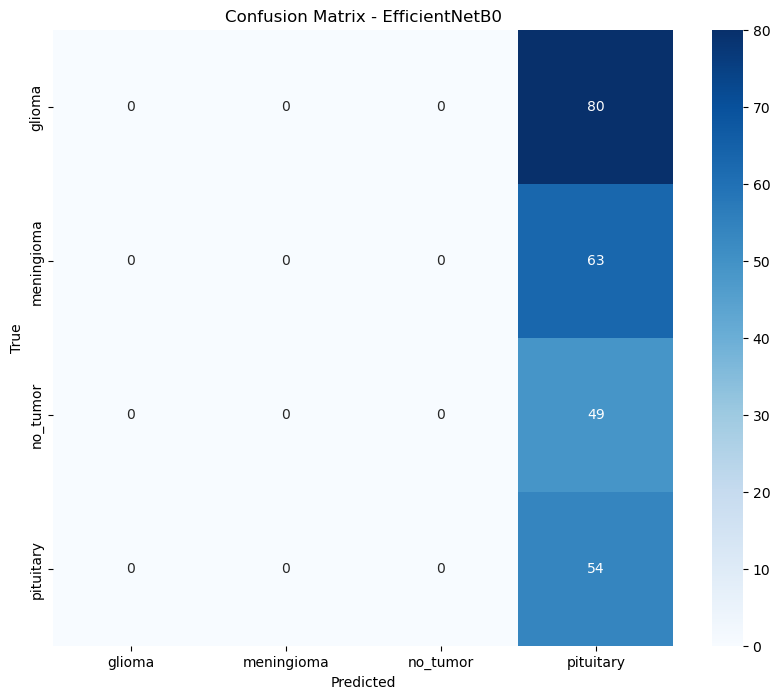

In [67]:
test_generator.reset()
test_loss, test_acc, test_precision, test_recall = efficientnet_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

predictions = efficientnet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

conf_mat = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EfficientNetB0')
plt.show()

In [68]:
def evaluate_resnet():
    base_model = ResNet50V2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze all layers (initially)
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    resnet50_model = models.Model(inputs, outputs)
    resnet50_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall'])

    resnet_history = resnet50_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    return resnet50_model,resnet_history

resnet50_model, resnet_history = evaluate_resnet()
model_comparison.append({
    'Model': 'ResNet50V2',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet50_model.count_params():,}",
    'Inference Time': 'Slow',
    'Best For': 'High accuracy tasks'
})

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2901 - loss: 1.6047 - precision: 0.3156 - recall: 0.0979 - val_accuracy: 0.5398 - val_loss: 1.1630 - val_precision: 0.8308 - val_recall: 0.1076
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4134 - loss: 1.2915 - precision: 0.5011 - recall: 0.1146 - val_accuracy: 0.5916 - val_loss: 1.0923 - val_precision: 0.7640 - val_recall: 0.2709
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.4960 - loss: 1.1955 - precision: 0.6687 - recall: 0.1680 - val_accuracy: 0.5896 - val_loss: 1.0627 - val_precision: 0.7713 - val_recall: 0.3426
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5143 - loss: 1.1458 - precision: 0.6736 - recall: 0.1850 - val_accuracy: 0.6175 - val_loss: 1.0042 - val_precision: 0.7841 - val_recall: 0.4124
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5240 - loss: 1.1365 - precision: 0.6840 - recall: 0.2408 - val_accuracy: 0.6175 - val_loss: 0.9779 - 

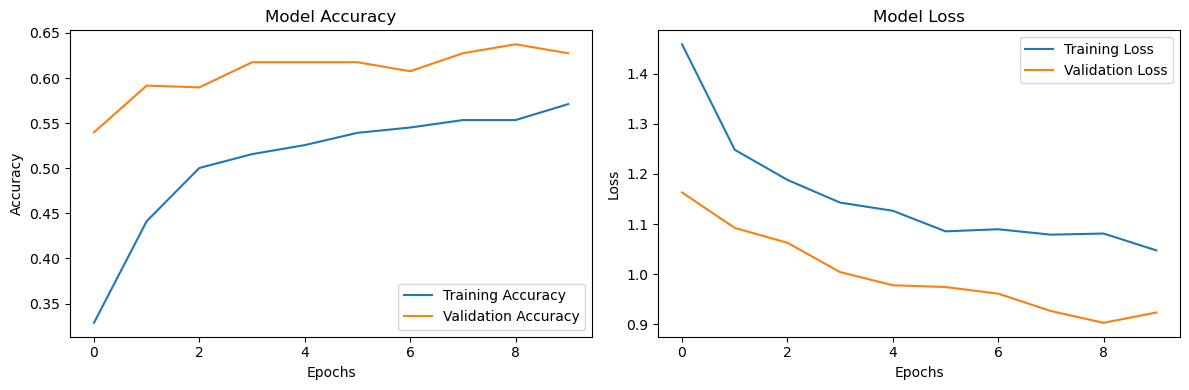

In [69]:
plot_history(resnet_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5679 - loss: 1.0429 - precision: 0.6865 - recall: 0.4118

Test accuracy: 0.6220
Test precision: 0.7421
Test recall: 0.4797
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.69      0.60      0.64        80
  meningioma       0.55      0.37      0.44        63
    no_tumor       0.55      0.73      0.63        49
   pituitary       0.67      0.85      0.75        54

    accuracy                           0.62       246
   macro avg       0.61      0.64      0.61       246
weighted avg       0.62      0.62      0.61       246



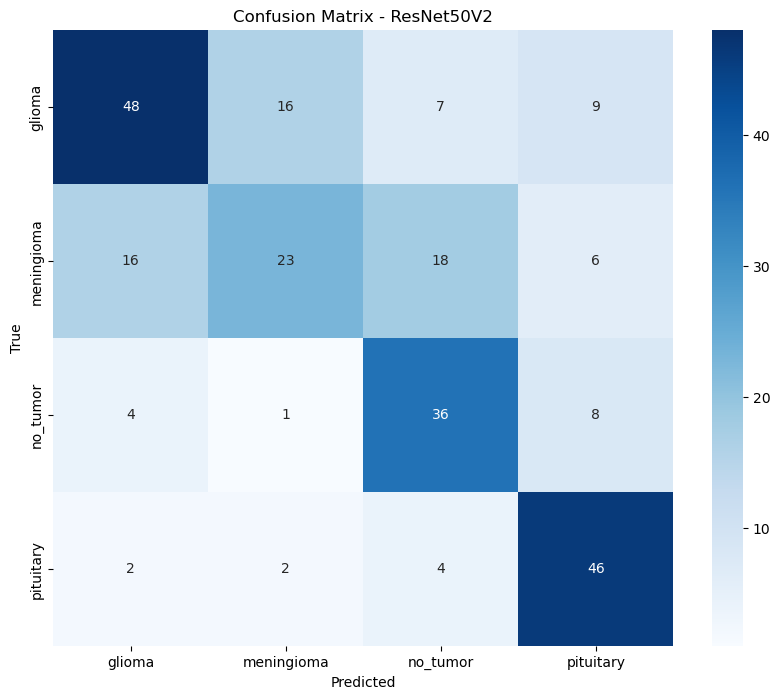

In [70]:
test_generator.reset()
test_loss, test_acc, test_precision, test_recall = resnet50_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

predictions = resnet50_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

conf_mat = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50V2')
plt.show()

In [53]:
def evaluate_inceptionV3():
    InceptionV3_train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'
    )
    InceptionV3_val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'
    )
    base_model = InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze all layers (initially)
    inception_model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    inception_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','precision', 'recall'])

    inception_history = inception_model.fit(
        InceptionV3_train_gen,
        validation_data=InceptionV3_val_gen,
        epochs=10,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )

    return inception_model,inception_history

inception_model, inception_history = evaluate_inceptionV3()
model_comparison.append({
    'Model': 'InceptionV3',
    'Val Accuracy': max(inception_history.history['val_accuracy']),
    'Val Precision': max(inception_history.history['val_precision']),
    'Val Recall': max(inception_history.history['val_recall']),
    'Parameters': f"{inception_model.count_params():,}",
    'Inference Time': 'Moderate',
    'Best For': 'Complex tasks'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 858s 10us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.4622 - loss: 1.3716 - precision: 0.5037 - recall: 0.3593 - val_accuracy: 0.7410 - val_loss: 0.6961 - val_precision: 0.7919 - val_recall: 0.6594
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6571 - loss: 0.8087 - precision: 0.7130 - recall: 0.6140 - val_accuracy: 0.7450 - val_loss: 0.6192 - val_precision: 0.7933 - val_recall: 0.7112
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7485 - loss: 0.6495 - precision: 0.7795 - recall: 0.6990 - val_accuracy: 0.7869 - val_loss: 0.5440 - val_precision: 0.8247 - val_recall: 0.7590
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7768 - loss: 0.5923 - precision: 0.8025 - recall: 0.7427 - val_accuracy: 0.8108 - val_loss: 0.4994 - val_precision: 0.8445 - val_recall: 0.7789
Epoch 5/10
53/53 ━━━━━━━━━━━━━━

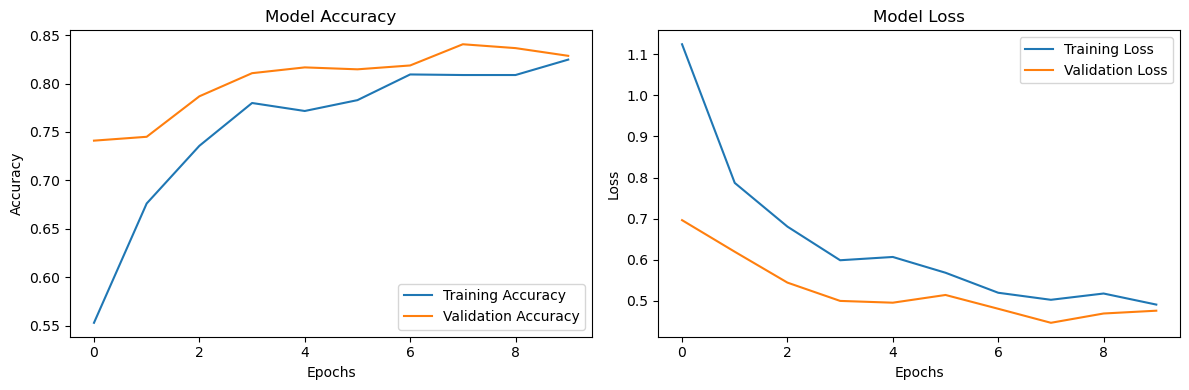

In [55]:
plot_history(inception_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6059 - loss: 0.9817 - precision: 0.7145 - recall: 0.4415

Test accuracy: 0.6301
Test precision: 0.7643
Test recall: 0.4878
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.70      0.65      0.68        80
  meningioma       0.51      0.41      0.46        63
    no_tumor       0.59      0.65      0.62        49
   pituitary       0.67      0.83      0.74        54

    accuracy                           0.63       246
   macro avg       0.62      0.64      0.62       246
weighted avg       0.62      0.63      0.62       246



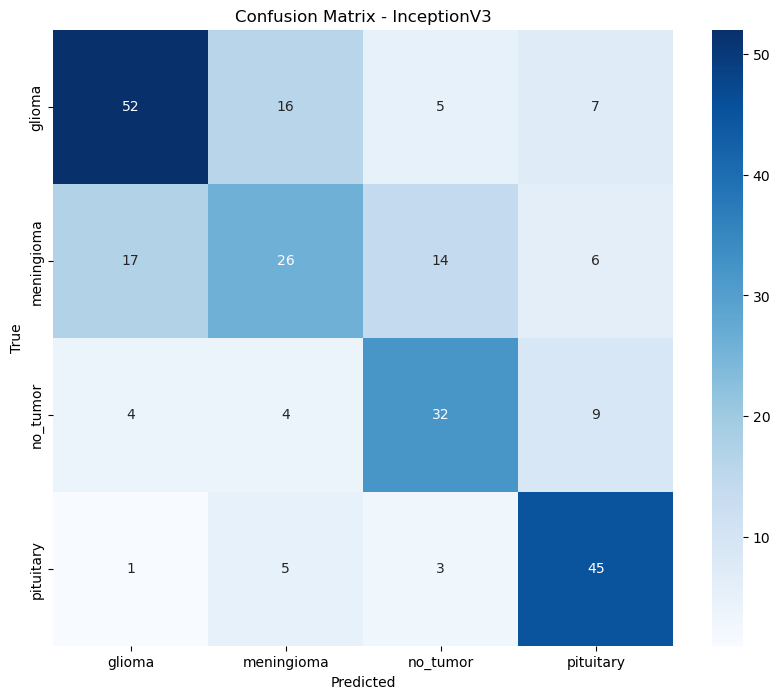

In [54]:
test_generator.reset()
test_loss, test_acc, test_precision, test_recall = resnet50_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

predictions = resnet50_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

conf_mat = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - InceptionV3')
plt.show()

MODEL COMPARISON

In [82]:
comparison = pd.DataFrame(model_comparison)
comparison = comparison.sort_values(by='Val Accuracy', ascending=False)
comparison

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
1,InceptionV3,0.840637,0.872881,0.820717,"21,810,980",Moderate,Complex tasks
0,MobileNet,0.702083,0.781437,0.583333,"2,263,108",Fast,Mobile/Edge devices
3,ResNet50V2,0.637450,0.830769,0.478088,"23,572,996",Slow,High accuracy tasks
2,EfficientNet,0.320717,0.000000,0.000000,"4,054,695",Moderate,Balanced performance


The best performing model is:
Model               InceptionV3
Val Accuracy           0.840637
Val Precision          0.872881
Val Recall             0.820717
Parameters           21,810,980
Inference Time         Moderate
Best For          Complex tasks
Name: 1, dtype: object


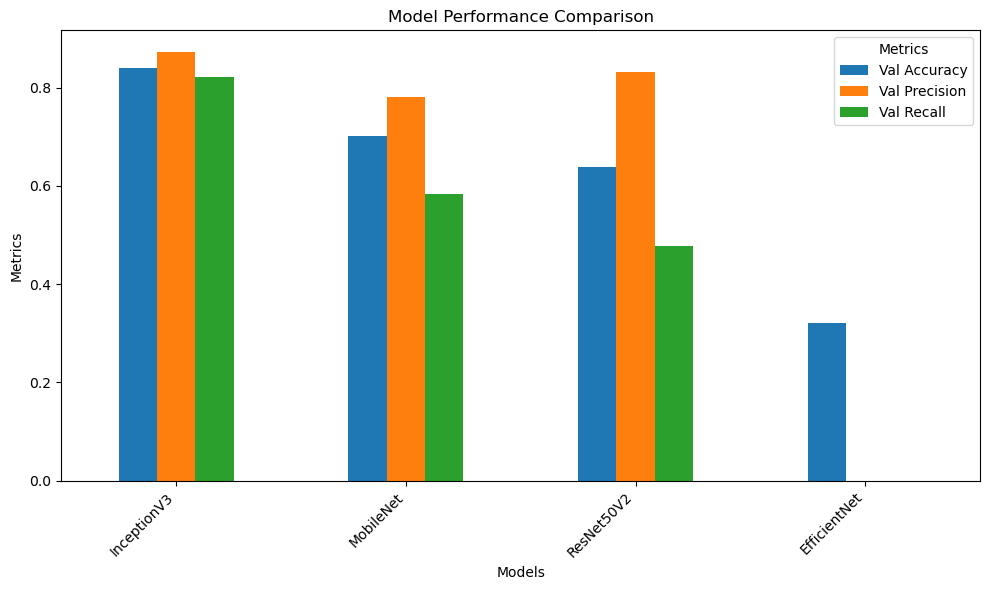

In [ ]:
#find the best model
df = comparison.copy()

best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [ ]:
#saving the best model
best_model = inception_model
best_model.save('best_model.h5')